


# Fixed Income and Credit
# Master in Computational Finance (MCF)

# 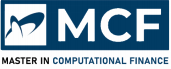

## Final Exam

**Professor**: N. Vasiljevic

## Yield Curve Fitting

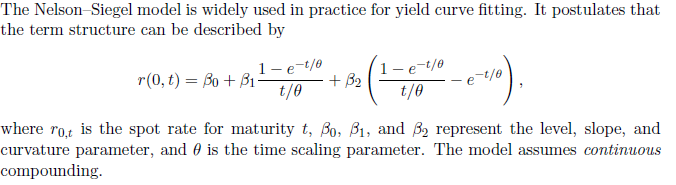

Installing third-party libraries that will be used in this problem set.

In [1]:
!pip install sympy==1.8.0
!pip install nelson_siegel_svensson # For this module, please see the documentation at: https://nelson-siegel-svensson.readthedocs.io/en/latest/index.html

Importing all libraries that will be used in this problem set.

In [2]:
from google.colab import files
from sympy import *
import plotly.graph_objects as go
import numpy as np
import pandas as pd

init_printing()

# Importing Nelson Siegel module
from nelson_siegel_svensson.calibrate import betas_ns_ols, errorfn_ns_ols

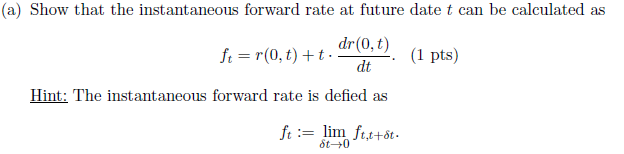

**Solution**

The price of zero-coupon bond is:

$p(0,t) = e ^{-r(0,t)\cdot t}$

where $r(0,t)$ is the spot rate.



$p(0,t) \cdot e ^{-r(0,t, t + \delta)\cdot\delta} = p(0,t+\delta)$

$r(r0,t,t+\delta) = - \frac {\ln p(0,t+\delta) - \ln p(0,t)} {\delta}$

$f_t := r(0, t, t) = \lim_{\delta \to \infty} r(0,t,t + \delta) =-\frac{\partial \ln p(0,t)}{\partial t}$ 

Now, let's substitute $p(0,t)$ with $e ^{-r(0,t)\cdot t}$:

$f_t = \frac {\partial (r(0,t) \cdot t)}{\partial t}$

This is derivative of a product, so we finally get:

$f_t = r(0,t) + t \cdot r'(0,t)$

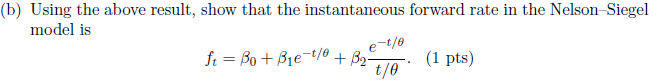

**Solution** 

In [3]:
beta_0, beta_1, beta_2, theta, t = symbols("beta_0, beta_1, beta_2, theta, t")

r_0t =  beta_0 + beta_1*((1-exp(-t/theta))/(t/theta)) + beta_2*(((1-exp(-t/theta))/(t/theta)) - exp(-t/theta))

Eq(symbols('r_{(0\,t)}'),r_0t)


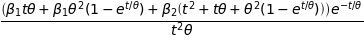

In [4]:
# First derivative of r(0,t)
r_prime_0t = diff(r_0t, t)

simplify(r_prime_0t)

In [5]:
# Defining equation from a) and substituting with given Nelson-Siegel model
f_t = r_0t + t*r_prime_0t

Eq(symbols('f_t'), simplify(f_t))

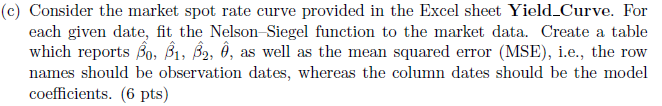

**Solution**

First of all, let's import the data from the Excell Sheet **Yield_Curve**.

In [6]:
# Uploading dataset: MCF21_FIC_Final_Exam_Group_5.xlsx
uploaded = files.upload()

Saving MCF21_FIC_Final_Exam_Group_5.xlsx to MCF21_FIC_Final_Exam_Group_5.xlsx


In [7]:
data = pd.read_excel(
    "MCF21_FIC_Final_Exam_Group_5.xlsx",
    sheet_name="Yield_Curve",
    index_col="Date",
    parse_dates=True)
    
data.head()

,0.25,0.50,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,15.00,20.00,25.00,30.00
Date,,,,,,,,,,,,,,,,
2005-01-31,2.501959,2.487722,2.592097,2.943724,3.202149,3.423589,3.651658,3.868167,4.043379,4.164626,4.239126,4.285156,4.566571,4.908547,4.913041,4.764336
2005-02-28,2.514755,2.554966,2.670398,3.002650,3.261893,3.498076,3.738654,3.958905,4.130506,4.245257,4.314413,4.358341,4.654025,4.969392,4.932886,4.776053
2005-03-31,2.591330,2.683589,2.875578,3.223132,3.439665,3.633873,3.842834,4.038923,4.190279,4.286941,4.339759,4.369234,4.618398,4.906485,4.855088,4.698126
2005-04-29,2.517156,2.560623,2.717892,3.058931,3.270032,3.457304,3.663990,3.861797,4.015974,4.114805,4.169049,4.200030,4.474787,4.790322,4.740261,4.579020
2005-05-31,2.460135,2.511626,2.638531,2.888095,3.081201,3.270949,3.466257,3.644104,3.785284,3.886944,3.959068,4.016228,4.341388,4.560621,4.478468,4.354495


We are going to use **OLS regression** framework, provided in the third-party library `nelson_siegel_svensson`.

In [8]:
# Defining fixed parameters
thetas = range(1,11) # Change for greater time scaling parameter
t = np.array([0.25, 0.5, 1, 2, 3, 4, 5, 6, 7, 8,9, 10, 15, 20, 25, 30]) # Maturities

In [9]:
# Fitting the models for the whole dataset and given thetas (betas_ns_ols function)
ns = {}
for index, row in data.iterrows():
  ns[str(index.date())] = [betas_ns_ols(theta, t, np.array(row)) for theta in thetas]

In [10]:
# Selecting a fitted model for each date that has least MSE (optimal)
ns_optimal = {}
for date, models in ns.items():
  ns_optimal[date] = sorted(ns[date], key=lambda x: x[1][1][0]/len(t))[0]

**Explanation**

Function `betas_ns_ols` returns a tuple of `NelsonSiegelSvenssonCurve` instance and other data (for example sum of squared errors).

The `NelsonSiegelSvenssonCurve` provides us all coefficients, as well as given *theta*. Fore more information about this class, please visit [source code](https://github.com/luphord/nelson_siegel_svensson/blob/master/nelson_siegel_svensson/ns.py#L18).

One of the data that is being returned in the tuple mentioned above is `sum of squared errors`. It is located at the index [1][1][0] of the tuple.

Since this is the sum of squared errors, and it is explicitly said in the problem set that we are looking for MSE (mean squared error), it needs to be divided by the number of observations per date (which is 16 in our case).



In [11]:
# Storing the results in the Pandas dataframe object
df = pd.DataFrame(columns=['Beta 0','Beta 1','Beta 2','Theta', 'MSE'], index=ns_optimal.keys())

for date, model in ns_optimal.items():
  df.loc[date] = pd.Series({'Beta 0': model[0].beta0, 'Beta 1': model[0].beta1, 'Beta 2': model[0].beta2, 'Theta': model[0].tau, 'MSE': model[1][1][0]/len(t)})

df

,Beta 0,Beta 1,Beta 2,Theta,MSE
2005-01-31,3.80541,-1.47314,5.56396,10,0.00327276
2005-02-28,3.60586,-1.2318,6.0621,10,0.00277849
2005-03-31,4.18475,-1.65799,4.27311,8,0.00278477
2005-04-29,3.49579,-1.0644,5.54304,10,0.00288677
2005-05-31,3.46233,-1.10953,4.93379,10,0.00159287
...,...,...,...,...,...
2021-01-29,1.95335,-1.86005,-2.023,3,0.000394072
2021-02-26,2.08845,-1.97843,-1.68073,2,0.000996655
2021-03-31,2.42326,-2.38992,-2.09314,2,0.00344702
2021-04-30,2.53319,-2.42675,-2.49221,2,0.00148732


image.png

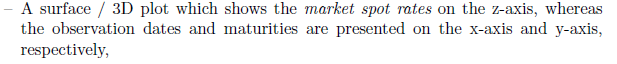

In [12]:
original_data = np.array(data.values).T
dates = list(ns_optimal.keys())

fig = go.Figure(data=[go.Surface(z=original_data, x=dates, y=t)])
fig.update_layout(title='Observed spot rates', autosize=False)
fig.show()

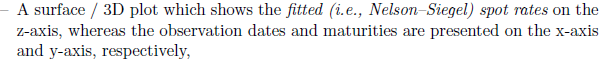

In [13]:
curves = np.array([curve[0](t) for curve in ns_optimal.values()]).T
fig = go.Figure(data=[go.Surface(z=curves, x=dates, y=t)])
fig.update_layout(title='Fitted spot rates', autosize=False)
fig.show()

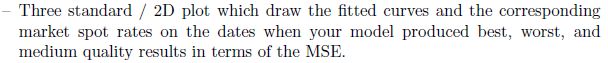

Let's find the best, worst and medium fitted curves based on the MSE.

We will sort the dataframe by MSE.

In [14]:
df_sorted = df.sort_values(by=['MSE'])
df_sorted

,Beta 0,Beta 1,Beta 2,Theta,MSE
2020-11-30,1.58771,-1.44902,-1.17561,4,0.00022957
2011-01-31,1.8556,-1.02093,8.38031,10,0.000283784
2020-12-31,1.67449,-1.57635,-1.32759,4,0.000306527
2011-04-29,2.02483,-1.0617,7.65097,10,0.000348097
2011-05-31,2.59406,-1.74193,5.8051,9,0.000391442
...,...,...,...,...,...
2009-01-30,2.7228,-2.08413,7.1344,10,0.020857
2008-12-31,4.3192,-3.49952,-3.8904,2,0.0259764
2009-03-31,3.16499,-3.02045,6.19825,10,0.0267772
2009-02-27,2.73764,-2.39708,7.3223,10,0.0280458


In [15]:
best = df_sorted.iloc[0]
best

Beta 0       1.58771
Beta 1      -1.44902
Beta 2      -1.17561
Theta              4
MSE       0.00022957
Name: 2020-11-30, dtype: object

In [16]:
worst = df_sorted.iloc[-1]
worst

Beta 0      4.73073
Beta 1     -3.13558
Beta 2     -3.41875
Theta             2
MSE       0.0282952
Name: 2008-11-28, dtype: object

In [17]:
number_of_rows = int(df_sorted.count()[0])
medium_index = number_of_rows/2 if number_of_rows % 2 == 0 else number_of_rows//2 + 1

medium = df_sorted.iloc[medium_index]
medium

Beta 0      4.01468
Beta 1    -0.520958
Beta 2    0.0299455
Theta             1
MSE       0.0029939
Name: 2005-12-30, dtype: object

The best model is at **2020-11-30** with MSE=0.00022957

The medium model is at **2005-12-30** with MSE=0.0029939

The worst model is at **2008-11-28** with MSE=0.0282952

In [18]:
best_curve = ns_optimal[best.name][0]
medium_curve = ns_optimal[medium.name][0]
worst_curve = ns_optimal[worst.name][0]

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=best_curve(t),
                    mode='lines',
                    name='Best fitted curve'))
fig.add_trace(go.Scatter(x=t, y=data.loc['2020-11-30'],
                    mode='markers',
                    name='Observations'))

fig.update_layout(title='Best fitted curve and orginal data for 2020-11-30.',
                   xaxis_title='Maturity',
                   yaxis_title='Spot Rate')

fig.show()

In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=medium_curve(t),
                    mode='lines',
                    name='Medium fitted curve'))
fig.add_trace(go.Scatter(x=t, y=data.loc['2005-12-30'],
                    mode='markers',
                    name='Observations'))

fig.update_layout(title='Medium fitted curve and orginal data for 2005-12-30.',
                   xaxis_title='Maturity',
                   yaxis_title='Spot Rate')

fig.show()

In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=worst_curve(t),
                    mode='lines',
                    name='Worst fitted curve'))
fig.add_trace(go.Scatter(x=t, y=data.loc['2008-11-28'],
                    mode='markers',
                    name='Observations'))

fig.update_layout(title='Worst fitted curve and orginal data for 2008-11-28.',
                   xaxis_title='Maturity',
                   yaxis_title='Spot Rate')

fig.show()

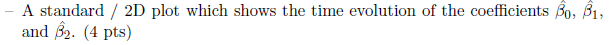

In [22]:
beta_0 = np.array(df['Beta 0'])
beta_1 = np.array(df['Beta 1'])
beta_2 = np.array(df['Beta 2'])

dates = list(ns_optimal.keys())

fig = go.Figure()
fig.add_trace(go.Scatter(x=dates, y=beta_0,
                    mode='lines',
                    name='Beta 0'))
fig.add_trace(go.Scatter(x=dates, y=beta_1,
                    mode='lines',
                    name='Beta 1'))
fig.add_trace(go.Scatter(x=dates, y=beta_2,
                    mode='lines', 
                    name='Beta 2'))

fig.update_layout(title='Evolution of coefficients Beta 0, Beta 1 and Beta 2',
                   xaxis_title='Date',
                   yaxis_title='Value')

fig.show()